## Initial sRRR exploration on Purkinje cell firing rates and locomotion

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

from sparseRRR import elastic_rrr, elastic_rrr_bootstrap, elastic_rrr_cv, dimensionality, bibiplot, plot_cv_results
from sklearn.exceptions import ConvergenceWarning

In [2]:
def preprocess(data):
    X = data['Firing rate']
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['Locomotion']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return X,Y

In [3]:
data = pickle.load(open('../data/purkinje.pickle', 'rb'))

X,Y = preprocess(data)
cell_names = data['cell_names']
locomotion_names = data['locomotion_names']

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (2691968, 105) 
Shape of Y: (2691968, 4)


It is a lot of timepoints, so let us play around with reduced data set sizes.

In [4]:
slice = np.linspace(0, 10000, 10000, dtype=int)
slice

array([    0,     1,     2, ...,  9997,  9998, 10000])

Bootstrapping (see later) seems to suggest that a certain 10 cells are always selected. Let us select them here with an appropriate $\alpha$ value (regularization strength) and l1_ratio for rank $r=2$ models.

In [8]:
w,v = elastic_rrr(X[slice,:], Y[slice,:], rank=2, alpha=.31, l1_ratio=1)

print('\nNeurons selected: {}'.format(np.sum(w[:,0]!=0)))
print(cell_names[w[:,0]!=0])


Neurons selected: 10
[b'MC4017_S2' b'MC5003_S21' b'MC5003_S25' b'MC5003_S28' b'MC5005_S14'
 b'MC5005_S5' b'MC5005_S6' b'MC5005_S8' b'MC6001_S5' b'MC6001_S7']


Text(0.5, 1.0, 'Sorted row l2-norms of $W$')

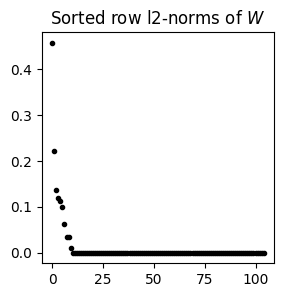

In [9]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(np.sort(np.linalg.norm(w, axis=1))[::-1], '.', color='black')
ax.set_title(r'Sorted row l2-norms of $W$')

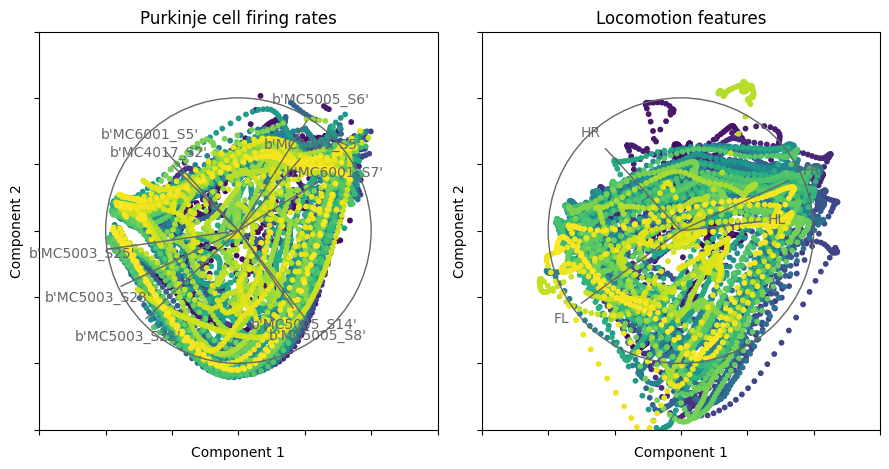

In [10]:
bibiplot(X[slice,:], Y[slice,:], w, v, 
         titles = ['Purkinje cell firing rates', 'Locomotion features'],
         YdimsNames = locomotion_names, 
         XdimsNames = cell_names
         )

In [24]:
alphas = np.concatenate((np.arange(.1,1.01,.1), np.arange(2,7)))
l1_ratios = np.array([.25, .5, .75, 1])

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=(ConvergenceWarning, RuntimeWarning))
    cvResults = elastic_rrr_cv(X[slice,:], Y[slice,:], l1_ratios=l1_ratios, alphas=alphas)


1.......... Time: 0.0h  4m 15s


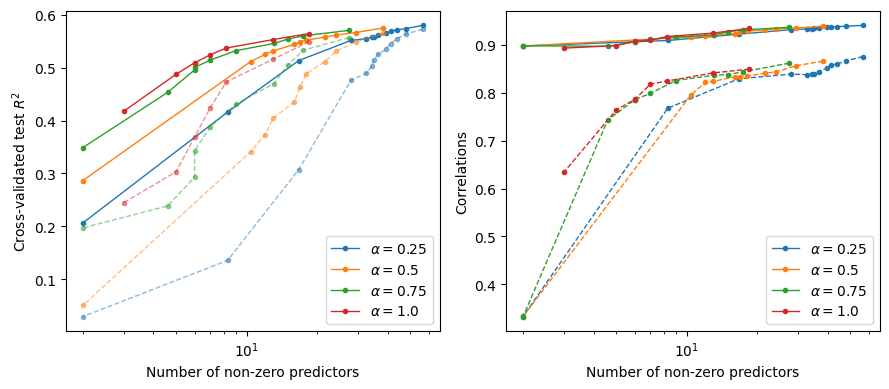

In [31]:
plot_cv_results(*cvResults, l1_ratios)

In [12]:
bootCounts = elastic_rrr_bootstrap(X[slice,:], Y[slice,:], alpha=.31, l1_ratio=1)

args = np.argsort(bootCounts)[::-1]
print('')
for i in range(20):
    print('{:10} {:.2f}'.format(cell_names[args[i]], bootCounts[args[i]]))

.................................................................................................... 

b'MC5003_S28' 1.00
b'MC5003_S25' 1.00
b'MC5005_S8' 1.00
b'MC4017_S2' 1.00
b'MC5005_S14' 1.00
b'MC5005_S6' 1.00
b'MC5003_S21' 1.00
b'MC5005_S5' 1.00
b'MC6001_S5' 1.00
b'MC6001_S7' 0.85
b'MC5003_S17' 0.47
b'MC6001_S11' 0.10
b'MC3808_S2' 0.01
b'MC5003_S13' 0.00
b'MC4017_S7' 0.00
b'MC4017_S8' 0.00
b'MC4017_S9' 0.00
b'MC5003_S27' 0.00
b'MC5003_S10' 0.00
b'MC5003_S11' 0.00


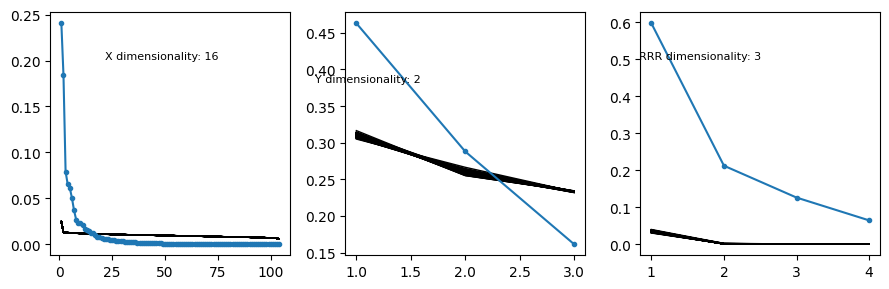

In [29]:
# A quick and dirty way to estimate the dimensionality
dimensionality(X[slice,:], Y[slice,:])